### 1. Data Prepreation

In [1]:
# importing Libraries

import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from tqdm.notebook import tqdm, tnrange
from PIL import Image
import os
%matplotlib inline

In [2]:
# Extract the dataset
!unzip -qq -o /content/drive/MyDrive/food-101.zip


In [3]:
# Function to re-arrange the dataset

def file_move(source, dest):
  """## 
  ## Function to move and pad file
  ## sourc: location where file located
  ## dest: File save Destination"""
  img = Image.open(source)                                     ## Opening Image File
  img_size = img.size
  target_size = max(img_size)
  ratio = 1.0
  new_size = tuple([int(x*ratio) for x in img_size])
  img = img.resize(new_size, Image.ANTIALIAS)
  new_img = Image.new("RGB", (target_size, target_size))
  new_img.paste(img, ((target_size-new_size[0])//2,
                        (target_size-new_size[1])//2))
  new_img.save(dest) 

In [4]:
##  imported paths
image_dir = '/content/food-101/images/'
meta_dir = '/content/food-101/meta/'
train_data_dir = '/content/data/train/'
test_data_dir = '/content/data/test/'
eval_dir= '/content/data/eval/'

In [5]:
# create training data
df_train = pd.read_json(meta_dir +'train.json')  ##  Loading Traning meta Data.
df_train.columns

Index(['churros', 'hot_and_sour_soup', 'samosa', 'sashimi', 'pork_chop',
       'spring_rolls', 'panna_cotta', 'beef_tartare', 'greek_salad',
       'foie_gras',
       ...
       'chicken_quesadilla', 'pho', 'prime_rib', 'cheesecake', 'ice_cream',
       'omelette', 'grilled_cheese_sandwich', 'lobster_roll_sandwich',
       'nachos', 'oysters'],
      dtype='object', length=101)

In [6]:
train_cat = ['donuts',                              #
             'dumplings',                           #  Training  categories 
             'french_fries',                        #
             'frozen_yogurt',
             'ramen']

In [7]:
for col in train_cat:                                         #   with individual columns.
    if os.path.isdir(train_data_dir +col)!=True:                                            
        os.makedirs(train_data_dir +col)                 ##  creating Directory for training data.
    for i in range(len(df_train)):
        source_loc = image_dir + str(df_train[col][i])+'.jpg'
        dest_loc = train_data_dir + str(df_train[col][i])+'.jpg'
        file_move(source_loc, dest_loc)

In [8]:
## Total number of samples in train folder
train_images = glob(train_data_dir +'/*/*.jpg')

print(f"Total number of samples in train folder = {len(train_images)}")

Total number of samples in train folder = 3750


In [9]:
# create testing data
df_test = pd.read_json(meta_dir +'test.json')    ##  Loading Traning meta Data.
test_cat = ['donuts', 'dumplings', 'french_fries',            ##  Training  categories 
            'frozen_yogurt', 'ramen']                         
for col in test_cat:                                         #   with individual columns.
    if os.path.isdir(test_data_dir +col)!=True:                                            
        os.makedirs(test_data_dir +col)                 ##  creating Directory for training data.
    for i in range(len(df_test)):
        source_loc = image_dir + str(df_train[col][i])+'.jpg'
        dest_loc = test_data_dir + str(df_train[col][i])+'.jpg'
        file_move(source_loc, dest_loc)

In [10]:
# Creating Evalution Set From Test Set
for col in test_cat:
    image_dir = test_data_dir + col +'/*.jpg'
    dest_dir = eval_dir+col
    if os.path.isdir(dest_dir)!=True:                                            
        os.makedirs(dest_dir)
    for i in range(50):
        img_path=np.random.choice(glob(image_dir))
        shutil.move(img_path, dest_dir)

In [11]:
test_images = glob(test_data_dir + '/*/*.jpg')
print(f"Total number of samples in test folder = {len(test_images)}")

Total number of samples in test folder = 1000


In [12]:
data_dir = '/content/Data/'
eval_dir = '/content/eval'

### 2. Preprocessing

In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
batch_size= 64
data_dir = './data'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'eval']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test', 'eval']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'eval']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
## Defining pretrained model
model = models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [15]:
model.features

Sequential(
  (0): ConvBNActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(in

In [16]:
# old model classifier
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [17]:
## Loss

criterion = nn.CrossEntropyLoss()
model = model.to(device)

## Optimiser
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### 3. Training Model

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    ep = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1 , num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                desc = "EPOCHS {:0>4d}".format(epoch+1)
                model.train()  # Set model to training mode
                emu = tqdm(dataloaders['train'], desc= desc)
            else:
                model.eval()   # Set model to evaluate mode
                emu = dataloaders['test']

            
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in emu:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                ep = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'In Epoch : {ep}')
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [19]:
epochs = 15
model = train_model(model,criterion,optimizer, scheduler,num_epochs= epochs)

Epoch 1/15
----------



train Loss: 2.2406 Acc: 0.6803
test Loss: 0.2236 Acc: 0.9380

Epoch 2/15
----------



train Loss: 0.3820 Acc: 0.8904
test Loss: 0.0951 Acc: 0.9690

Epoch 3/15
----------



train Loss: 0.2581 Acc: 0.9128
test Loss: 0.0764 Acc: 0.9720

Epoch 4/15
----------



train Loss: 0.2348 Acc: 0.9192
test Loss: 0.0664 Acc: 0.9720

Epoch 5/15
----------



train Loss: 0.2067 Acc: 0.9333
test Loss: 0.0509 Acc: 0.9800

Epoch 6/15
----------



train Loss: 0.1827 Acc: 0.9381
test Loss: 0.0417 Acc: 0.9860

Epoch 7/15
----------



train Loss: 0.1580 Acc: 0.9464
test Loss: 0.0315 Acc: 0.9900

Epoch 8/15
----------



train Loss: 0.1388 Acc: 0.9528
test Loss: 0.0261 Acc: 0.9930

Epoch 9/15
----------



train Loss: 0.1329 Acc: 0.9539
test Loss: 0.0252 Acc: 0.9940

Epoch 10/15
----------



train Loss: 0.1228 Acc: 0.9568
test Loss: 0.0251 Acc: 0.9940

Epoch 11/15
----------



train Loss: 0.1220 Acc: 0.9576
test Loss: 0.0218 Acc: 0.9970

Epoch 12/15
----------



train Loss: 0.1156 Acc: 0.9605
test Loss: 0.0214 Acc: 0.9960

Epoch 13/15
----------



train Loss: 0.1242 Acc: 0.9595
test Loss: 0.0224 Acc: 0.9940

Epoch 14/15
----------



train Loss: 0.1212 Acc: 0.9579
test Loss: 0.0209 Acc: 0.9930

Epoch 15/15
----------



train Loss: 0.1121 Acc: 0.9627
test Loss: 0.0202 Acc: 0.9950

In Epoch : 10
Training complete in 10m 55s
Best val Acc: 0.997000


In [37]:
def visualize_model(model, num_images=250):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['eval']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            

            for j in range(inputs.size()[0]):
                print(f'actual: {class_names[labels[j]]}')
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

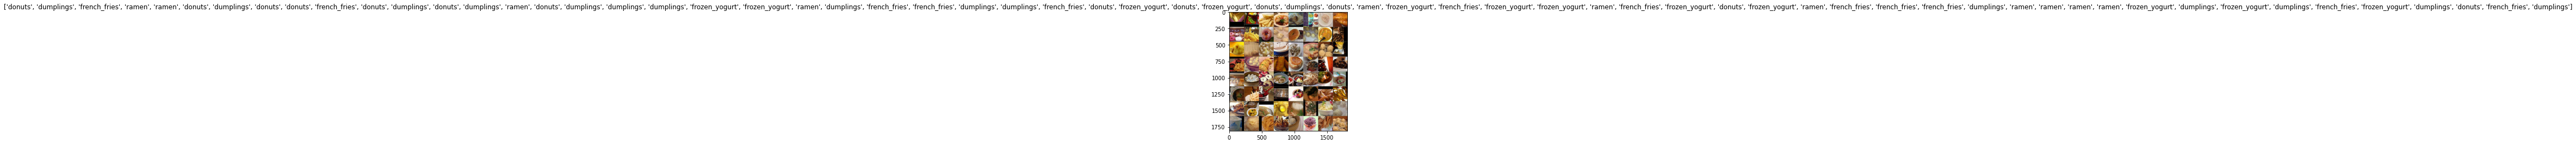

In [38]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




actual: french_fries


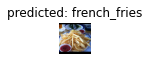

actual: ramen


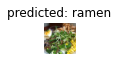

actual: dumplings


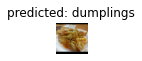

actual: frozen_yogurt


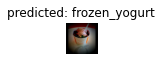

actual: ramen


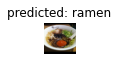

actual: dumplings


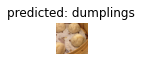

actual: dumplings


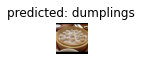

actual: french_fries


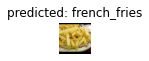

actual: dumplings


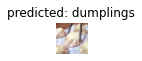

actual: frozen_yogurt


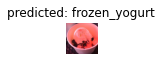

actual: donuts


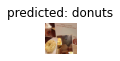

actual: french_fries


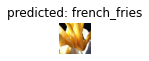

In [39]:
visualize_model(model, num_images=12)